In [1]:
import os


import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imread
from torch.utils import data
from skimage.io import imread
from torchvision import transforms, utils, models
from torch.utils.data import DataLoader
from torchmetrics.functional import jaccard_index, dice_score

### Загрузка Dataseta

Стуктура датасета:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [2]:
images = []
lesions = []
root = "dataset"

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))


In [3]:
print("Размерность изображения: ", images[0].shape)
print("Размерность маски: ", lesions[0].shape)

Размерность изображения:  (572, 765, 3)
Размерность маски:  (572, 765)


Изображения в представленных данных могут быть разных размеров.
Делаем размер одинаковым 256*256.

In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)

In [6]:
print("Размерность изображения: ", X[0].shape)
print("Размерность маски: ", Y[0].shape)

Размерность изображения:  (256, 256, 3)
Размерность маски:  (256, 256)


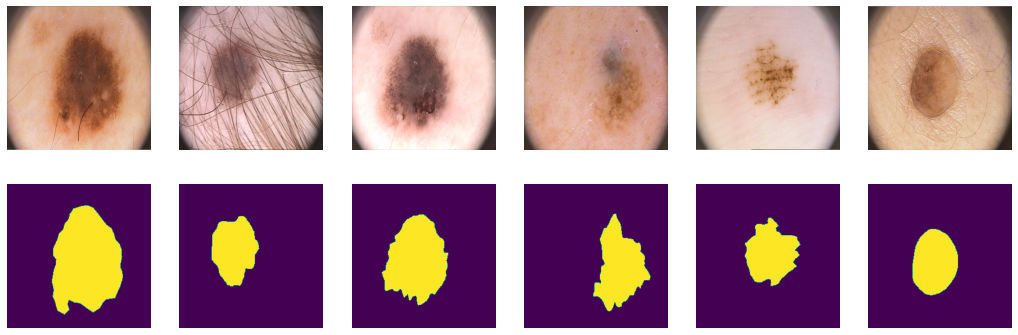

In [7]:

# from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

### DataSet

Преобразование загруженных данных в tensor

In [8]:
class SegmentationDataSet(data.Dataset):
    def __init__(self,
                 inputs: list,
                 targets: list,
                 transform=None
                 ):
        self.inputs = inputs
        self.targets = targets
        self.transform = transform
        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.long

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self,
                    index: int):
        # Select the sample
        x = self.inputs[index]
        y = self.targets[index]

        # Preprocessing
        if self.transform is not None:
            x = self.transform(x)
            y = self.transform(y)
            y = torch.round(y)
    
        return x, y

In [9]:
dataset = SegmentationDataSet(inputs = X,
                              targets = Y,
                              transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize((256, 256))
                       ]))

### DataLoader

In [11]:
dataset_size = len(dataset)
tr_size = int(0.8 * dataset_size)
val_size = int(0.12 * dataset_size)
ts_size  = int(0.08 * dataset_size)
train, valid, test = torch.utils.data.random_split(dataset, [tr_size, val_size, ts_size])

In [12]:
batch_size = 3
train_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test, batch_size=batch_size, shuffle=True)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Метрики качества

In [14]:
def transform_pred(pred):
    """
    Трансформация картинки из (N, С, W, H) в (N, W, H, C),
    или из (С, W, H) в (W, H, C)
    """
    if len(pred.shape) == 4:
        pred = pred.permute(0, 2, 3, 1)
    # single predict
    if len(pred.shape) == 3:
        pred = pred.permute(1, 2, 0)
    return pred

# Метрика качества IOU

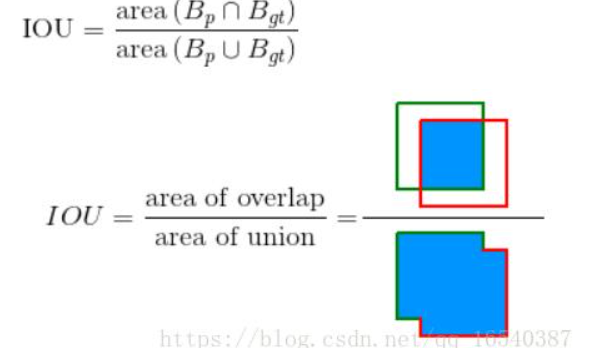

In [15]:
def iou_metrix(pred, gt):
    """
    Подсчет метрики IOU.
    Метрика считается при помощи библиотеки  
    torchmetrics.functional.
    
    :param pred: предсказания модели.
    :param gt: исходные данные.
    
    :return: Значение метрики IOU.
    """
    if len(pred.shape) == 4:
        gt = gt.reshape((gt.shape[0], gt.shape[2], gt.shape[3]))
        
    pred = torch.max(transform_pred(pred),axis=-1)[1]
    return jaccard_index(pred, gt.to(torch.uint8), 2)

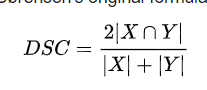

In [16]:
def dice_metrix(pred, gt):
    """
    Подсет метрики dice.
    
    :param pred: предсказания модели.
    :param gt: исходные данные.
    
    :return: Значение метрики dice.
    """
    if len(pred.shape) == 4:
        gt = gt.reshape((gt.shape[0], gt.shape[2], gt.shape[3]))
        
    pred = transform_pred(pred)
    # превращаем картину и предсказания в вектор
    pred = pred.reshape(-1, pred.shape[-1])
    gt = gt.reshape(-1)
    dice = dice_score(pred, gt)
    return dice

In [17]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler=None):
    """
    Обучение модели
    """
    X_val, Y_val = next(iter(data_val))
    Y_val = Y_val.reshape((Y_val.shape[0], Y_val.shape[2], Y_val.shape[3])).to(torch.long)
    train_loss = []
    val_loss = []
    iou_score = []
    dice_score = []
    valid_loss_min = np.Inf
    
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in tqdm(data_tr):
            # data to device
            Y_batch = Y_batch.reshape((Y_batch.shape[0], Y_batch.shape[2], Y_batch.shape[3]))
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(torch.long).to(device)

            # set parameter gradients to zero
            opt.zero_grad()
            
            # forward
            Y_pred =model(X_batch)
            if isinstance(Y_pred, OrderedDict):
                    Y_pred = Y_pred['out']
                    
           #            print("y_pred", Y_batch)
            loss =  loss_fn(Y_pred, Y_batch)
            loss.backward()  # backward-pass
            opt.step()  # update weights

           
            avg_loss += loss.item() / len(data_tr)
        train_loss.append(avg_loss)
        toc = time()
        print('loss: %f' % avg_loss)

        if scheduler is not None:
            scheduler.step(avg_loss)
            #print(opt.param_groups[0]['lr'])
        
        # show intermediate results
        model.eval()  # testing mode
        X_val, Y_val = X_val.to(device), Y_val.to(device)
        Y_hat = model(X_val)
        if isinstance(Y_hat, OrderedDict):
            Y_hat = Y_hat['out']
        loss = loss_fn(Y_hat, Y_val)
        Y_hat = torch.sigmoid(Y_hat)
        val_loss.append(loss.item()/len(data_val))
        
        iou = score_model(model, iou_metrix, data_val)
        iou_score.append(iou)
        dice= score_model(model, dice_metrix, data_val)
        dice_score.append(dice)

        print('loss valid: %f' % val_loss[-1])
        
        
         # сохраняем веса лучшей модели
        if val_loss[-1] <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            val_loss[-1]))
            torch.save(model.state_dict(), 'model.pt')
            valid_loss_min = val_loss[-1]

        Y_hat, X_val, Y_val = Y_hat.detach().to('cpu'), X_val.to('cpu'), Y_val.to('cpu')
        Y_hat = torch.max(transform_pred(Y_hat),axis=-1)[1]
#         print("Shape", Y_hat.shape)

        # Visualize tools
        clear_output(wait=True)
        batch_size = Y_val.shape[0]
        for k in range(batch_size):
            plt.subplot(2, batch_size, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, batch_size, k+batch_size+1)
            plt.imshow(Y_hat[k], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        torch.cuda.empty_cache()
    
    # загружаем модель с лучшими весами
    model.load_state_dict(torch.load('model.pt'))
    print('loading best model state')

    # выводим график обучения
    plt.plot(range(epochs), val_loss)
    plt.title('val_loss')
    plt.show()

    plt.plot(range(epochs), train_loss)
    plt.title('train_loss')
    plt.show()

    return val_loss, train_loss, iou_score, dice_score

In [18]:
def predict(model, data):
    """
    Предсказание модели.
    """
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [19]:
def score_model(model, metric, data):
    """
    Оценка модели на тестовой выборке.
    """
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            X_batch = X_batch.to(device)
            Y_label = Y_label.to(device)
            Y_pred = model(X_batch)
            #Y_pred = (Y_pred >= 0.5)
            if isinstance(Y_pred, OrderedDict):
                Y_pred = Y_pred['out']
            Y_pred = torch.sigmoid(Y_pred)
            scores += metric(Y_pred.cpu(), Y_label.cpu()).mean().item()
    return scores/len(data)

### Unet v2

U-Net — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.


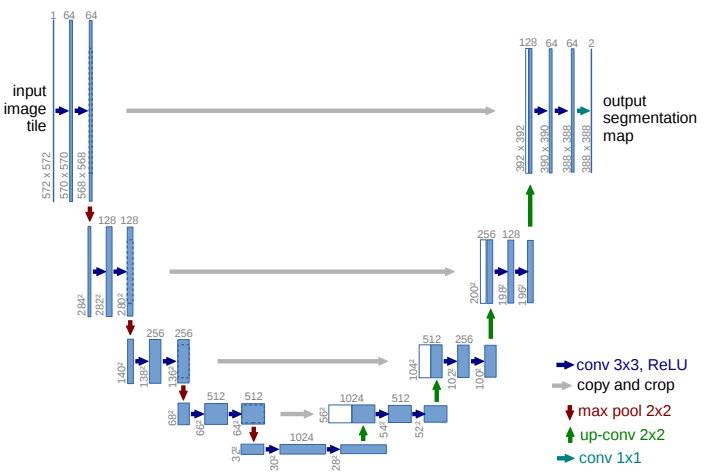

In [20]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import models
from torch.optim import lr_scheduler
from time import time
from tqdm.notebook import tqdm

from IPython.display import clear_output
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

from collections import OrderedDict

In [21]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=out_channels),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU(inplace=True)
    )  

class Unet2(nn.Module):
    def __init__(self):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)
        self.dconv_down5 = double_conv(512, 1024)      

        self.maxpool = nn.MaxPool2d(2)
        self.upsample4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dconv_up4 = double_conv(512 + 1024, 512)

        self.upsample3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dconv_up3 = double_conv(256 + 512, 256)

        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dconv_up2 = double_conv(128 + 256, 128)

        self.upsample1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.upsample0 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.conv_last = nn.Conv2d(64, 2, 1)
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)  

        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4)

        conv5 = self.dconv_down5(x)
        x = self.maxpool(conv5)

        x = self.upsample4(x)
        x = torch.cat((x, conv5), dim=1)
        x = self.dconv_up4(x)
        
        x = self.upsample3(x)
        x = torch.cat((x, conv4), dim=1)
        x = self.dconv_up3(x)

        x = self.upsample2(x)
        x = torch.cat((x, conv3), dim=1)
        x = self.dconv_up2(x)

        x = self.upsample1(x)
        x = torch.cat((x, conv2), dim=1)   
        x = self.dconv_up1(x)
        
        x = self.upsample0(x)
        out = self.conv_last(x)
        
        return out

In [21]:
def testing_models(model, epochs, loss, data_tr, data_val, data_ts, model_name):
    """
    Запуск обучения. Подсчет метрик на обучение и тесте.
    Запуск тестирования.
    """
    global tesing_results
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        patience=5,
        threshold=1e-4,
        mode="min"
        )
    
    val_loss, _, iou_valid_scores, dice_valid_scores = train(model, optimizer, loss, epochs, data_tr, data_val, scheduler)
    iou_test_score = score_model(model, iou_metrix, data_ts)
    dice_test_score = score_model(model, dice_metrix, data_ts)

    tesing_results = tesing_results.append(
        pd.Series([
               model_name,
               iou_valid_scores[len(iou_valid_scores)-1],
               iou_test_score,
               dice_valid_scores[len(iou_valid_scores)-1],
               dice_test_score],
              index=tesing_results.columns),
              ignore_index=True)
    return val_loss, iou_valid_scores, dice_valid_scores

In [22]:
tesing_results = pd.DataFrame(columns=['model', 'iou_val_score', 'iou_test_score', 'dice_val_score', 'dice_test_score'])
max_epochs = 40
loss = nn.CrossEntropyLoss()

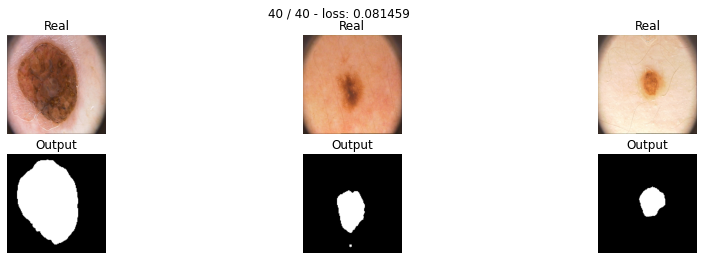

loading best model state


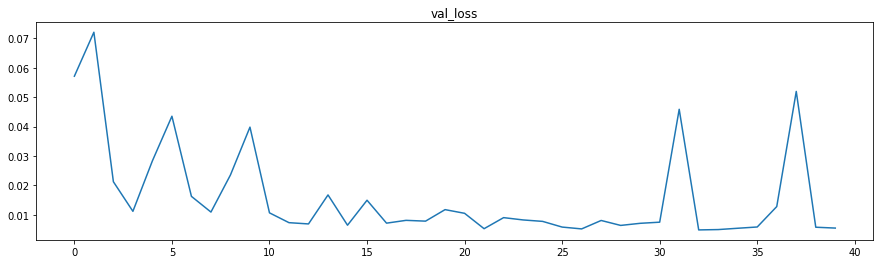

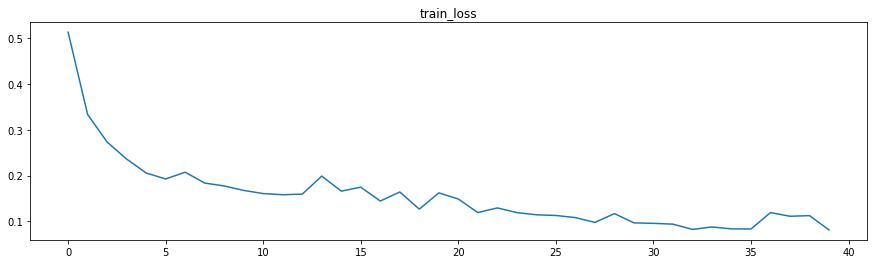

In [24]:
# Unet v2
model_unet2_dice = Unet2().to(device)

unet2_val_loss, unet2_iou_valid_scores, unet2_dice_valid_scores = testing_models(
    model_unet2_dice,
    max_epochs,
    loss,
    train_dl,
    valid_dl,
    test_dl,
    'unet2'
    )

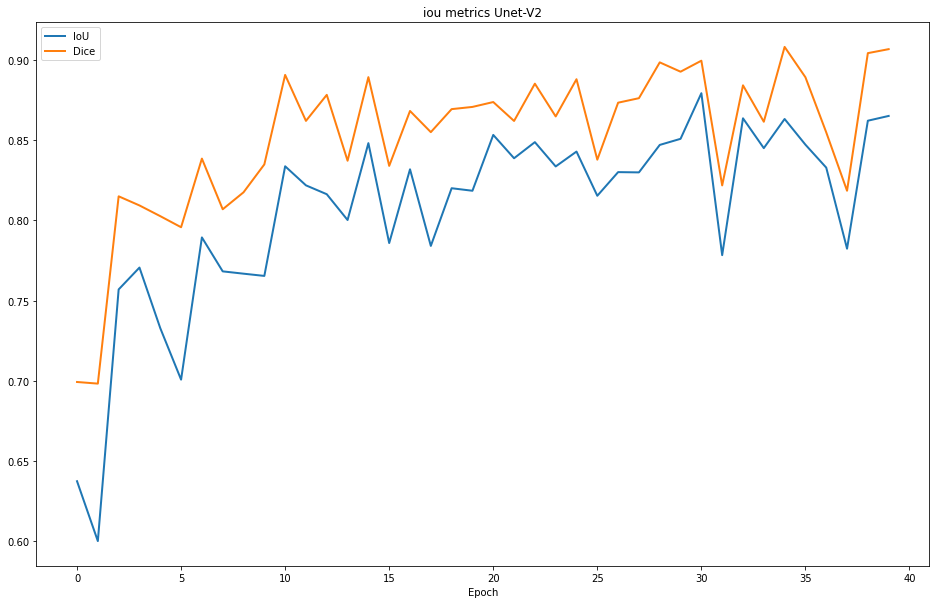

In [25]:
plt.figure(figsize=(16, 10))
plt.title("iou metrics Unet-V2")
plt.plot(range(max_epochs), unet2_iou_valid_scores, label="IoU", linewidth=2)
plt.plot(range(max_epochs), unet2_dice_valid_scores, label="Dice", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [26]:
tesing_results

,model,iou_val_score,iou_test_score,dice_val_score,dice_test_score
0,unet2,0.865216,0.882046,0.906875,0.91465


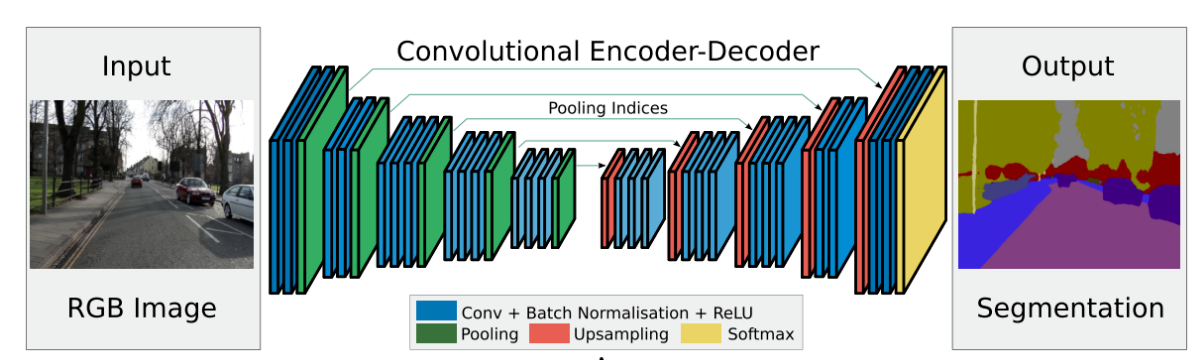

In [23]:
class SegNet(nn.Module):

    def __init__(self, num_cls = 2):
        super(SegNet, self).__init__()

        #SegNet Architecture
        #Takes input of size in_chn = 3 (RGB images have 3 channels)
        #Outputs size label_chn (N # of classes)

        #ENCODING consists of 5 stages
        #Stage 1, 2 has 2 layers of Convolution + Batch Normalization + Max Pool respectively
        #Stage 3, 4, 5 has 3 layers of Convolution + Batch Normalization + Max Pool respectively

        #General Max Pool 2D for ENCODING layers
        #Pooling indices are stored for Upsampling in DECODING layers

        self.in_chn = 3
        self.out_chn = num_cls

        self.MaxEn = nn.MaxPool2d(2, stride=2, return_indices=True) 

        self.ConvEn11 = nn.Conv2d(self.in_chn, 64, kernel_size=3, padding=1)
        self.ConvEn12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNEn12 = nn.BatchNorm2d(64)

        self.ConvEn21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.ConvEn22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNEn22 = nn.BatchNorm2d(128)

        self.ConvEn31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.ConvEn32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.ConvEn33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNEn33 = nn.BatchNorm2d(256)

        self.ConvEn41 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.ConvEn42 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.ConvEn43 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.BNEn43 = nn.BatchNorm2d(512)

        self.ConvEn51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.ConvEn52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.ConvEn53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn53 = nn.BatchNorm2d(512)


        #DECODING consists of 5 stages
        #Each stage corresponds to their respective counterparts in ENCODING

        #General Max Pool 2D/Upsampling for DECODING layers
        self.MaxDe = nn.MaxUnpool2d(2, stride=2) 

        self.ConvDe53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.ConvDe52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.ConvDe51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe51 = nn.BatchNorm2d(512)

        self.ConvDe43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.ConvDe42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.ConvDe41 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.BNDe41 = nn.BatchNorm2d(256)

        self.ConvDe33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.ConvDe32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.ConvDe31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.BNDe31 = nn.BatchNorm2d(128)

        self.ConvDe22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.ConvDe21 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.BNDe21 = nn.BatchNorm2d(64)

        self.ConvDe12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.ConvDe11 = nn.Conv2d(64, self.out_chn, kernel_size=3, padding=1)
        
        self.endAct = nn.Sigmoid()

    def forward(self, x):
        #ENCODE LAYERS
        #Stage 1
        x = F.relu(self.ConvEn11(x)) 
        x = F.relu(self.BNEn12(self.ConvEn12(x))) 
        x, ind1 = self.MaxEn(x)
        size1 = x.size()

        #Stage 2
        x = F.relu(self.ConvEn21(x)) 
        x = F.relu(self.BNEn22(self.ConvEn22(x))) 
        x, ind2 = self.MaxEn(x)
        size2 = x.size()

        #Stage 3
        x = F.relu(self.ConvEn31(x)) 
        x = F.relu(self.ConvEn32(x)) 
        x = F.relu(self.BNEn33(self.ConvEn33(x))) 	
        x, ind3 = self.MaxEn(x)
        size3 = x.size()

        #Stage 4
        x = F.relu(self.ConvEn41(x)) 
        x = F.relu(self.ConvEn42(x)) 
        x = F.relu(self.BNEn43(self.ConvEn43(x))) 	
        x, ind4 = self.MaxEn(x)
        size4 = x.size()

        #Stage 5
        x = F.relu(self.ConvEn51(x)) 
        x = F.relu(self.ConvEn52(x)) 
        x = F.relu(self.BNEn53(self.ConvEn53(x))) 	
        x, ind5 = self.MaxEn(x)
        size5 = x.size()

        #DECODE LAYERS
        #Stage 5
        x = self.MaxDe(x, ind5, output_size=size4)
        x = F.relu(self.ConvDe53(x))
        x = F.relu(self.ConvDe52(x))
        x = F.relu(self.BNDe51(self.ConvDe51(x)))

        #Stage 4
        x = self.MaxDe(x, ind4, output_size=size3)
        x = F.relu(self.ConvDe43(x))
        x = F.relu(self.ConvDe42(x))
        x = F.relu(self.BNDe41(self.ConvDe41(x)))

        #Stage 3
        x = self.MaxDe(x, ind3, output_size=size2)
        x = F.relu(self.ConvDe33(x))
        x = F.relu(self.ConvDe32(x))
        x = F.relu(self.BNDe31(self.ConvDe31(x)))

        #Stage 2
        x = self.MaxDe(x, ind2, output_size=size1)
        x = F.relu(self.ConvDe22(x))
        x = F.relu(self.BNDe21(self.ConvDe21(x)))

        #Stage 1
        x = self.MaxDe(x, ind1)
        x = F.relu(self.ConvDe12(x))
        x = self.endAct(self.ConvDe11(x))
        return x

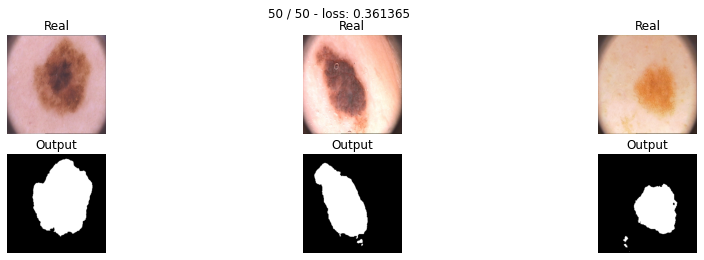

loading best model state


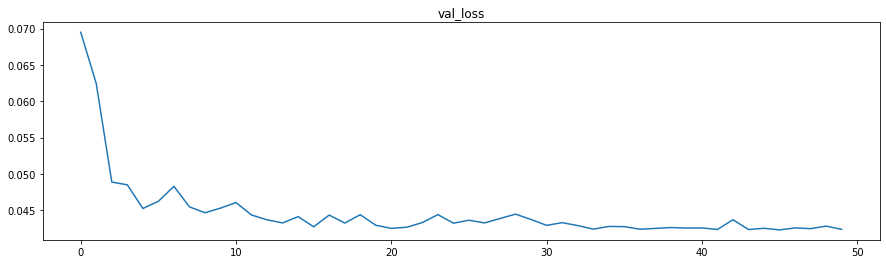

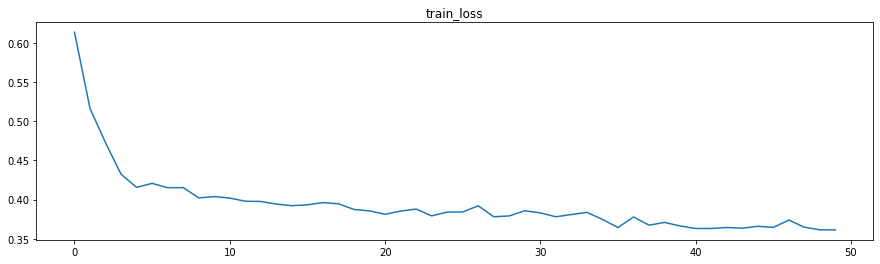

In [24]:
max_epochs = 50
model_segnet = SegNet().to(device)

segnet_val_loss, segnet_iou_valid_scores,segnet_dice_valid_scores = testing_models(
    model_segnet,
    max_epochs,
    loss,
    train_dl,
    valid_dl,
    test_dl,
    'unet2'
    )

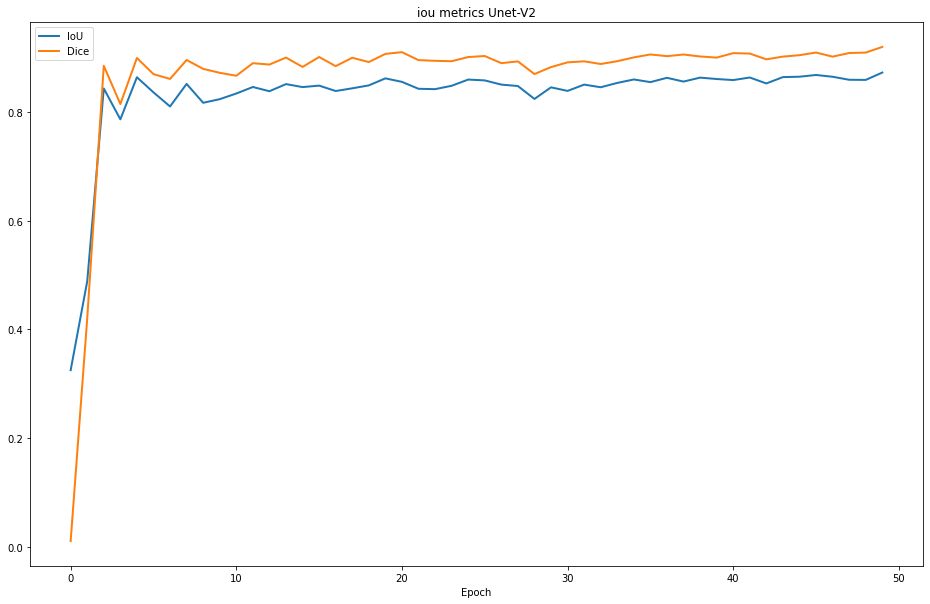

In [25]:
plt.figure(figsize=(16, 10))
plt.title("iou metrics Unet-V2")
plt.plot(range(max_epochs), segnet_iou_valid_scores, label="IoU", linewidth=2)
plt.plot(range(max_epochs), segnet_dice_valid_scores, label="Dice", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [26]:
tesing_results

,model,iou_val_score,iou_test_score,dice_val_score,dice_test_score
0,unet2,0.872199,0.866945,0.919357,0.90765


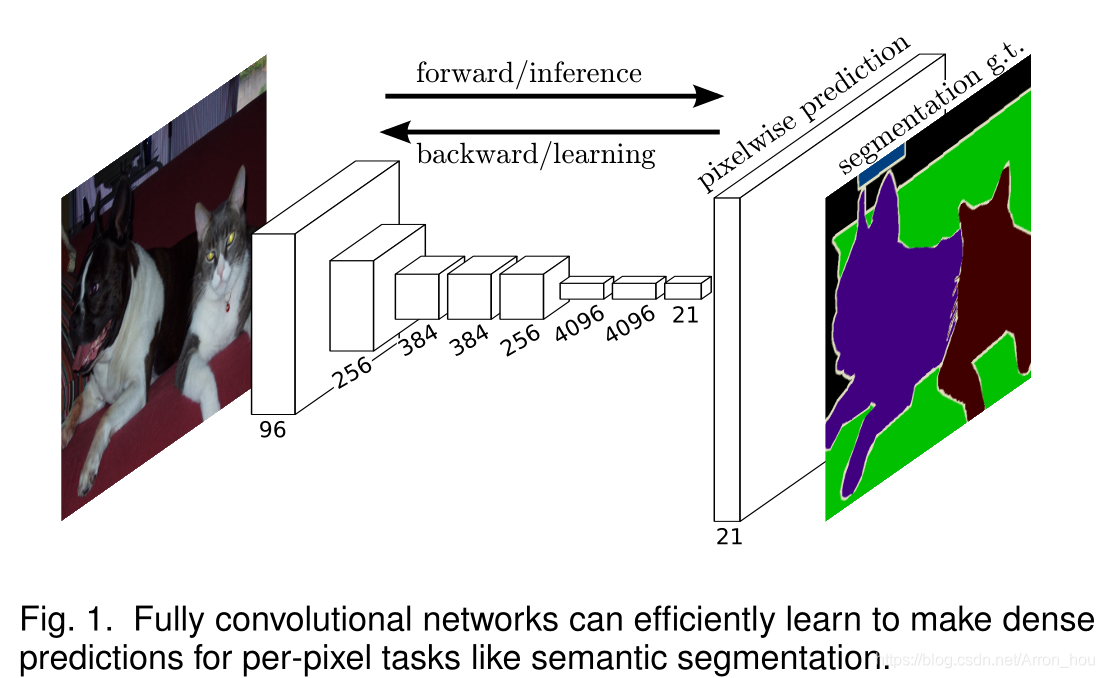

In [23]:
from torchvision.models.segmentation import fcn_resnet50
model_fcn_resnet50 = fcn_resnet50(num_classes = 2)

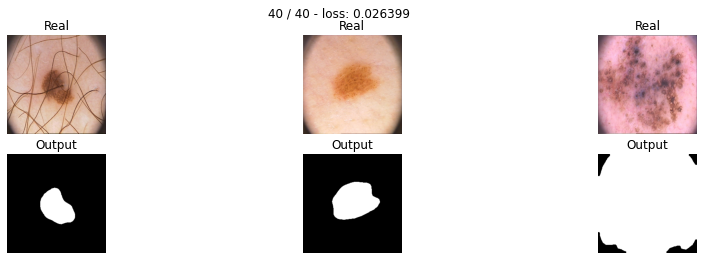

loading best model state


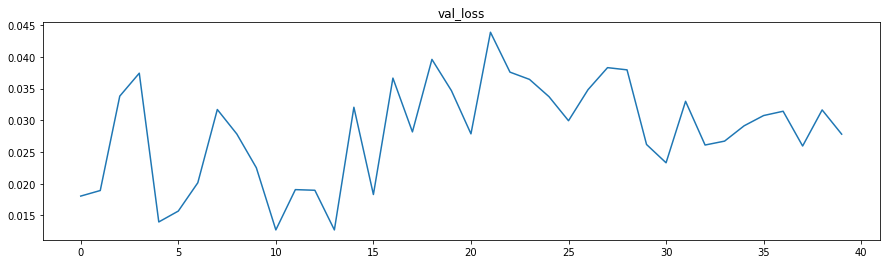

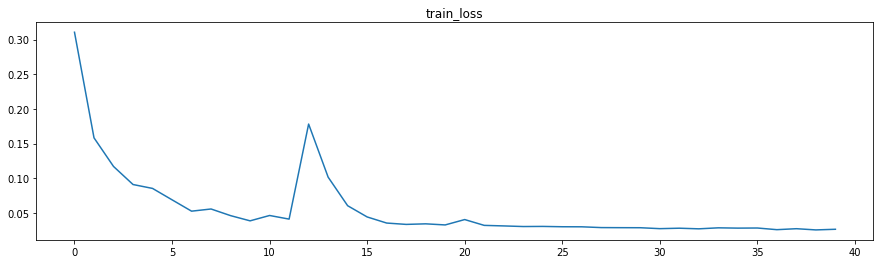

In [24]:
max_epochs = 40
model_fcn_resnet50 = model_fcn_resnet50.to(device)

resnetUNet_val_loss, resnetUNet_iou_valid_scores,resnetUNet_dice_valid_scores = testing_models(
    model_fcn_resnet50,
    max_epochs,
    loss,
    train_dl,
    valid_dl,
    test_dl,
    'ResNetUNet'
    )

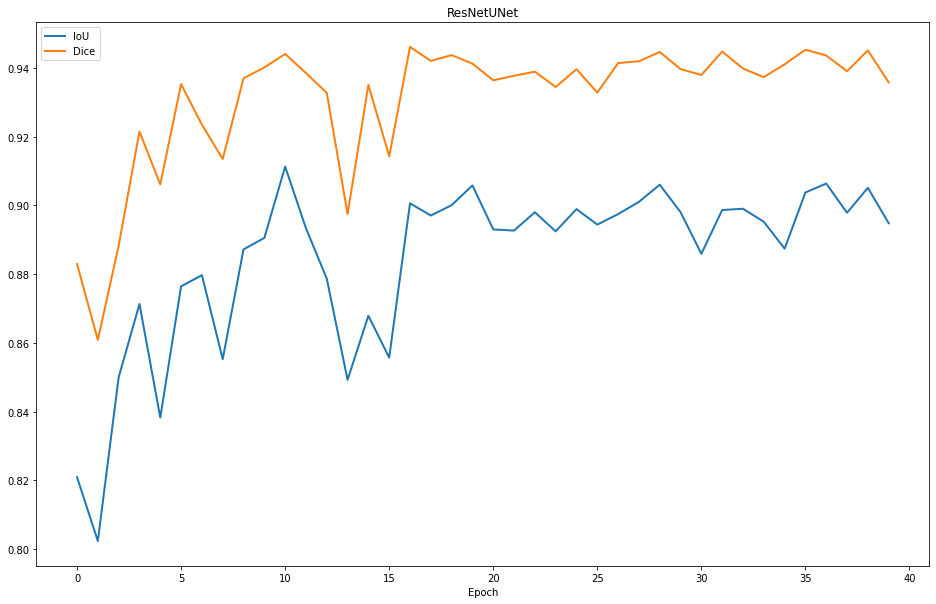

In [25]:
plt.figure(figsize=(16, 10))
plt.title("ResNetUNet")
plt.plot(range(max_epochs), resnetUNet_iou_valid_scores, label="IoU", linewidth=2)
plt.plot(range(max_epochs), resnetUNet_dice_valid_scores, label="Dice", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [26]:
tesing_results

,model,iou_val_score,iou_test_score,dice_val_score,dice_test_score
0,ResNetUNet,0.894831,0.923675,0.935813,0.938541
